In [1]:
!pip install num2words
!pip install contractions

     |████████████████████████████████| 101 kB 9.4 MB/s 
     |████████████████████████████████| 287 kB 40.3 MB/s 
     |████████████████████████████████| 106 kB 54.7 MB/s 


In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import sklearn
import operator
import requests
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
nltk.download('stopwords') 
nltk.download('punkt') 
nltk.download('wordnet') 

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import contractions
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords') 
stopwords=set(nltk.corpus.stopwords.words('english'))
stopwords.add("'s")
nltk.download('punkt') 
nltk.download('wordnet') 
lemmatizer = nltk.stem.WordNetLemmatizer()
from nltk.corpus import wordnet
from num2words import num2words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
def create_csv(text_file,label_file,output_file):

  dataset_text_file = open(text_file).readlines()

  dataset_label_file = open(label_file).readlines()

  data=[] 
  labels=[] 

  for line in dataset_text_file:
    data.append(line)
  for label in dataset_label_file:
    labels.append(label)

  datadict = {'text':data, 'label':labels}

  df = pd.DataFrame(datadict)
  df.to_csv(output_file)

create_csv('train_text.txt','train_labels.txt','./train_dataset.csv')
create_csv('test_text.txt','test_labels.txt','./test_dataset.csv')
create_csv('val_text.txt','val_labels.txt','./val_dataset.csv')

In [4]:
train_df = pd.read_csv('train_dataset.csv')
test_df = pd.read_csv('test_dataset.csv')
val_df = pd.read_csv('val_dataset.csv')

Training set
label
0    5217
1    3783
Name: label, dtype: int64


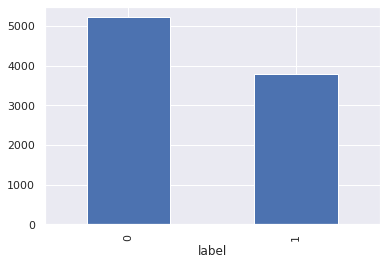

In [5]:
train_df.groupby('label').label.count().plot.bar(ylim=0)
print('Training set')
print(train_df.groupby('label').label.count())

Test set
label
0    1718
1    1252
Name: label, dtype: int64


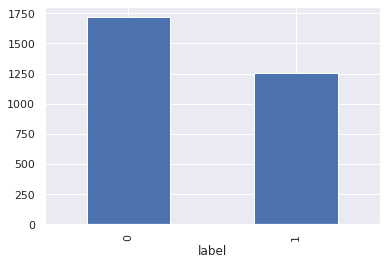

In [6]:
test_df.groupby('label').label.count().plot.bar(ylim=0)
print('Test set')
print(test_df.groupby('label').label.count())

Evaluation set
label
0    573
1    427
Name: label, dtype: int64


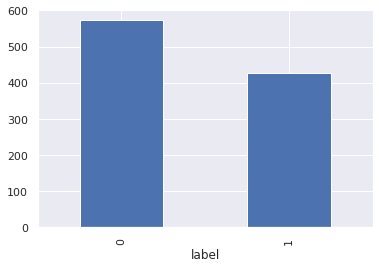

In [7]:
val_df.groupby('label').label.count().plot.bar(ylim=0)
print('Evaluation set')
print(val_df.groupby('label').label.count())


In [8]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def get_list_tokens(string):
  sentence_split=nltk.tokenize.sent_tokenize(string)
  list_tokens=[]
  for sentence in sentence_split:
    list_tokens_sentence=nltk.tokenize.word_tokenize(sentence)
    for token in list_tokens_sentence:
      list_tokens.append(lemmatizer.lemmatize(token).lower())
  return list_tokens

In [9]:
stopwords=set(nltk.corpus.stopwords.words('english'))

#stopwords.add(".")
#stopwords.add(",")
#stopwords.add("--")
#stopwords.add("``")

dict_word_frequency={}
for line in train_df['text']:
  sentence_tokens=get_list_tokens(line)
  for word in sentence_tokens:
    if word in stopwords: continue
    if word not in dict_word_frequency: dict_word_frequency[word]=1
    else: dict_word_frequency[word]+=1
      
sorted_list = sorted(dict_word_frequency.items(), key=operator.itemgetter(1), reverse=True)[:1000]
i=0
for word,frequency in sorted_list[:30]:
  i+=1
  print (str(i)+". "+word+" - "+str(frequency))
  
vocabulary=[]
for word,frequency in sorted_list:
  vocabulary.append(word)

1. # - 6791
2. @ - 6169
3. user - 6015
4. . - 5803
5. , - 4351
6. ! - 2283
7. ? - 1465
8. woman - 1201
9. bitch - 1129
10. refugee - 1098
11. 's - 1017
12. : - 1007
13. ’ - 966
14. immigrant - 955
15. ... - 909
16. n't - 897
17. & - 706
18. like - 692
19. migrant - 687
20. immigration - 653
21. ' - 636
22. illegal - 580
23. get - 546
24. - - 533
25. ; - 524
26. men - 521
27. people - 503
28. u - 478
29. cunt - 453
30. rape - 452


In [10]:
def clean_text(text):
    
    text = re.sub("[^a-zA-Z]", " ", text)
    
    text = ' '.join(text.split())
    text = text.lower()
    
    return text

In [11]:
train_df['clean_text'] = train_df['text'].apply(clean_text).str.replace('bn bn ', '')
train_df['clean_text'] = train_df['text'].apply(clean_text).str.replace(' bn ', '')

In [12]:
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 55.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    
    freq_dist = nltk.FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(freq_dist.keys()), 'count':list(freq_dist.values())})
    
    fig = plt.figure(figsize=(21,16))
    ax1 = fig.add_subplot(2,1,1)
    wordcloud = WordCloud(width=1000, height=300, background_color='black', 
                          max_words=1628, relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False).generate_from_frequencies(freq_dist)
    
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    
    
    ax2 = fig.add_subplot(2,1,2)
    d = words_df.nlargest(columns="count", n = terms) 
    ax2 = sns.barplot(data=d, palette = sns.color_palette('BuGn_r'), x= "count", y = "word")
    ax2.set(ylabel= 'Word')
    plt.show()

In [13]:
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stopwords]
    return ' '.join(no_stopword_text)
  
train_df['clean_text'] = train_df['clean_text'].apply(lambda x: remove_stopwords(x))

In [14]:
abbreviation = {
'TMR': 'TOMORROW',
'BOUT':'ABOUT' ,
'PLZ': 'PLEASE',
'B4': 'BEFORE',
"AFAIK":"As Far As I Know",
"ASAP":"As Soon As Possible",
"B4N":"Bye For Now",
"BRB":"Be Right Back",
"BTW":"By The Way",
"B4":"Before",
"GG":"Good Game",
"GN":"Good Night",
"GR8":"Great",
"IC":"I See",
"LTNS":"Long Time No See",
"PRT":"Party",
"THX":"Thank You",
"U2":"You Too",
"WTF":"What The FUCK",
"OMG":"OH MY GOD",
"BAMF":"BADASS MOTHER FUCKER",
"GTFO": "GET THE FUCK OUT",
"STFU": "SHUT THE FUCK UP",
"U":"YOU"

};


In [15]:
# remove duplicates
def remove_duplicates(df):
  df = df.drop_duplicates(keep="first")
  return df

# deal with missing value  
def deal_with_missing_value(df):
  df = df.drop(df[df['text'].map(len) <= 0].index)
  return df

# tag POS for the wordnet lemmatizer
def nltk_pos_tagger(nltk_tag):

    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def remove_url(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ' ')    
    return text

def remove_mention_hashtag(text):
    prefixes = ['@',"#"]
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in prefixes:
                words.append(word)
    return ' '.join(words)

def replacing_abbreviation_and_slang(text,abbreviation):
  rm =" "
  for word in text.split():
      word = word.upper()
      if word in abbreviation:
         word = word.replace(word, abbreviation[word])
      rm += word+" "

  return rm


def remove_emojis(text):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF"  
        u"\U00002500-\U00002BEF"  
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', text)



def preprocess(text):
    if type(text) is not int:
        # remove emojis
        text = remove_emojis(text)
        # remove url
        text = remove_url(text)
        # remove mention hashtag
        text = remove_mention_hashtag(text)
        # Expand  contractions
        text = contractions.fix(text)
        # replacing abbreviation and slang
        text = replacing_abbreviation_and_slang(text,abbreviation)
        
        # Replace every special char with space
        text = re.sub('[^a-zA-Z0-9\n]', ' ', text)
        # Remove Apostrophe with space
        text = re.sub("'", ' ', text)

        string = ""      
        # Convert number to word
        for word in text.split():
            if word.isdigit():
                string += num2words(word) + " "
            else: string += word+ " "
        # Replace every special char with space after Convert num 2 word
        string = re.sub('[^a-zA-Z0-9\n]', ' ', string)
        # Replace singil char with space
        string = re.sub('(?:^| )\w(?:$| )', ' ', string).strip()
        # Replace multiple spaces with single_space
        string = re.sub('\s+',' ', string)
        # Converting all the chars into lower case
        string = string.lower()
        # lemmatizer with POS tag
        lemmatizerstring=" "
        nltk_tagged = nltk.pos_tag(nltk.word_tokenize(string))  
        wordnet_tagged = map(lambda x: (x[0], nltk_pos_tagger(x[1])), nltk_tagged)
        lemmatized_sentence = []
        for word, tag in wordnet_tagged:
          if tag is None:
            lemmatizerstring+=word+ " "
          else:        
            lemmatizerstring+=lemmatizer.lemmatize(word, tag)+ " "
           
        # Remove Stop Words
        rm=""
        for word in lemmatizerstring.split():
            if not word in stopwords:
                rm += word + " "
    return rm.strip() # returned cleaned text

def data_preprocessing(train_data,val_data,test_data):
    print("Text Cleaning and Preprocessing")
    train_data['text'] = train_data['text'].apply(preprocess)
    val_data['text'] = val_data['text'].apply(preprocess)
    test_data['text'] = test_data['text'].apply(preprocess)
    print("Text Cleaning and Preprocessing .... Done")
    train_data = deal_with_missing_value(train_data)
    val_data = deal_with_missing_value(val_data)
    test_data = deal_with_missing_value(test_data)
    print("Removing missing Value .... Done")
    train_data = remove_duplicates(train_data)
    val_data = remove_duplicates(val_data)
    test_data = remove_duplicates(test_data)
    print("Removing Duplicates .... Done")
    return train_data,val_data,test_data

In [16]:
train_df,val_df,test_df=data_preprocessing(train_df,val_df,test_df)

Text Cleaning and Preprocessing
Text Cleaning and Preprocessing .... Done
Removing missing Value .... Done
Removing Duplicates .... Done


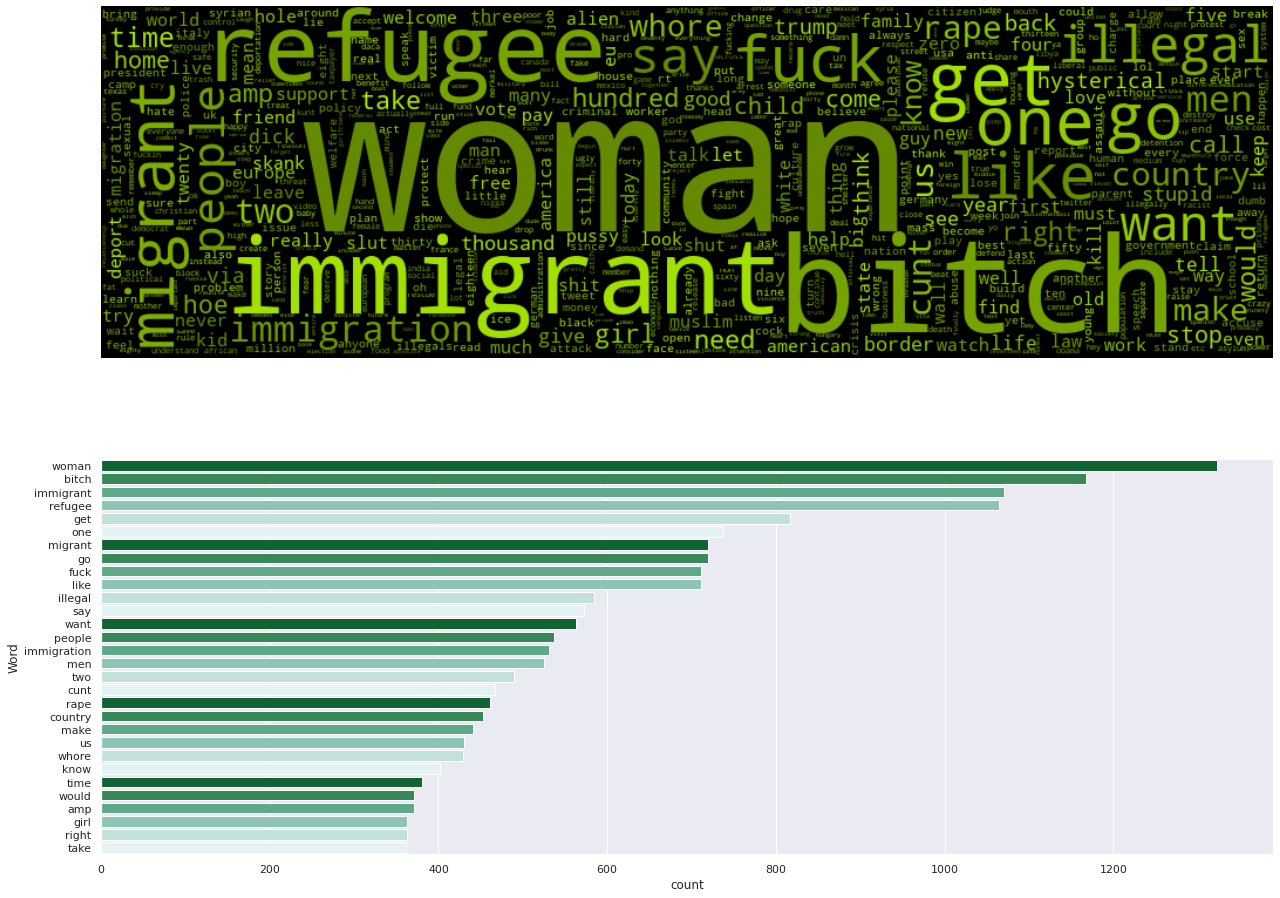

In [17]:
freq_words(train_df['text'], 30)

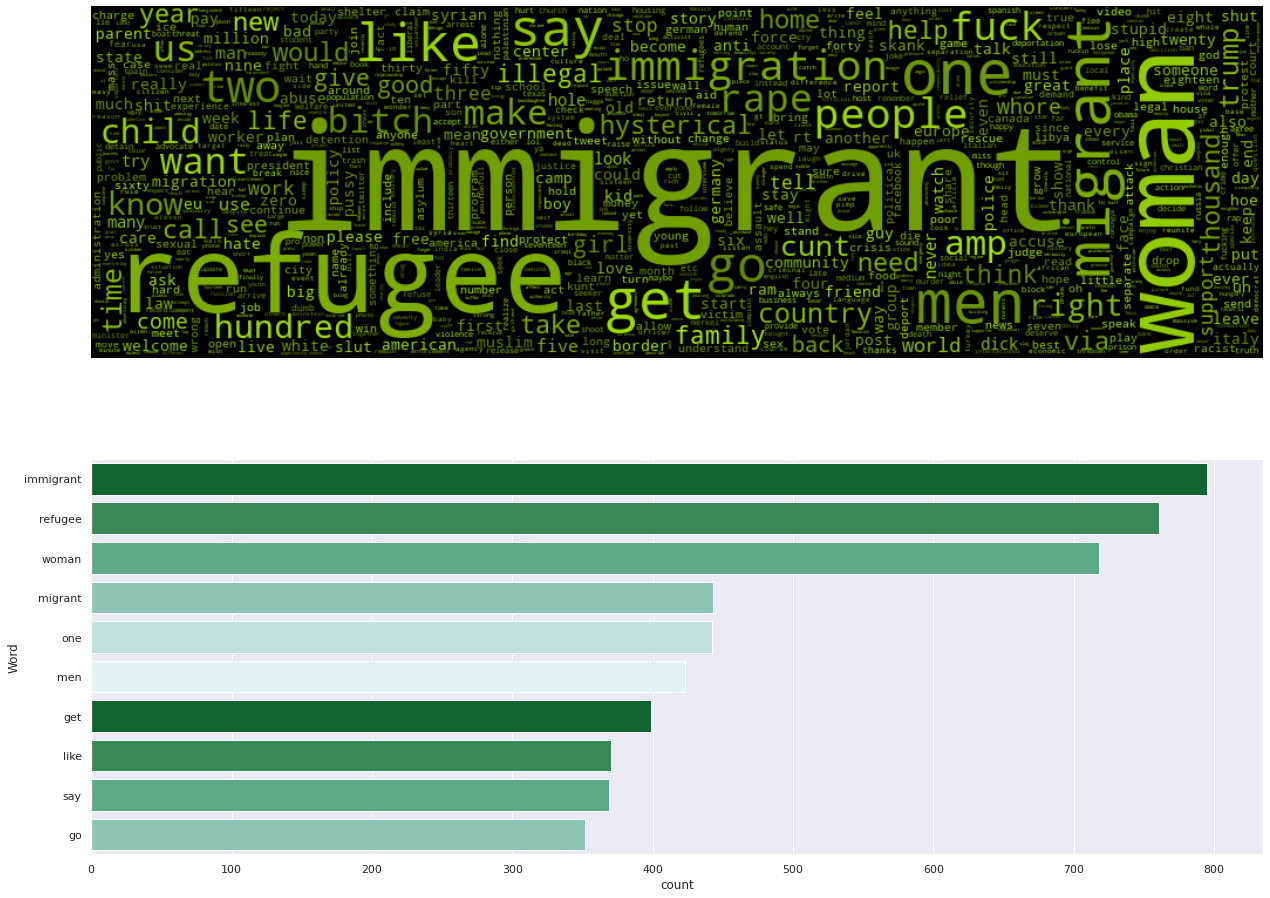

In [25]:
train_cloud=train_df[train_df['label']==0]
freq_words(train_cloud['text'], 10)

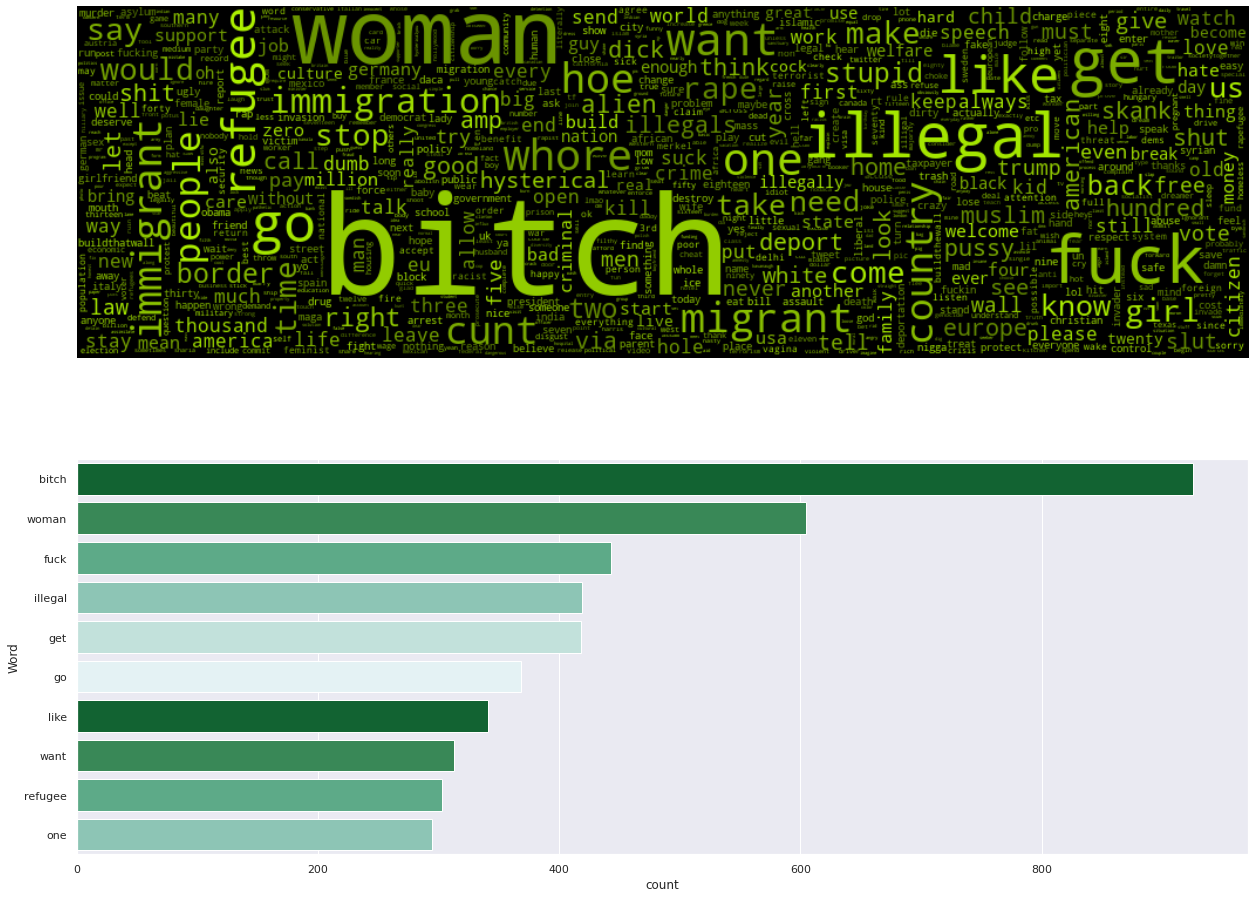

In [26]:
train_cloud=train_df[train_df['label']==1]
freq_words(train_cloud['text'], 10)

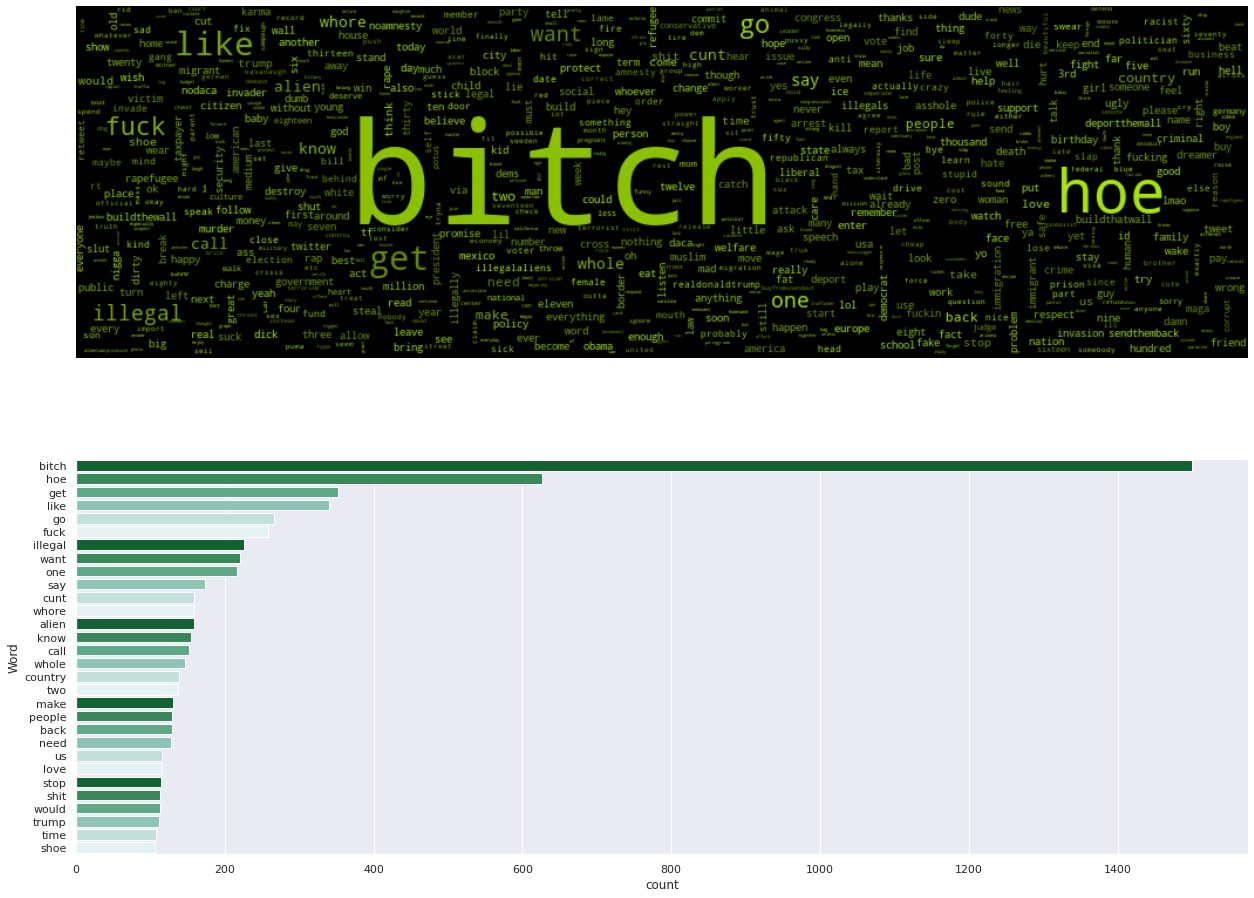

In [21]:
freq_words(test_df['text'], 30)

In [27]:
test_cloud=test_df[test_df['label']==0]
freq_words(test_cloud['text'], 10)

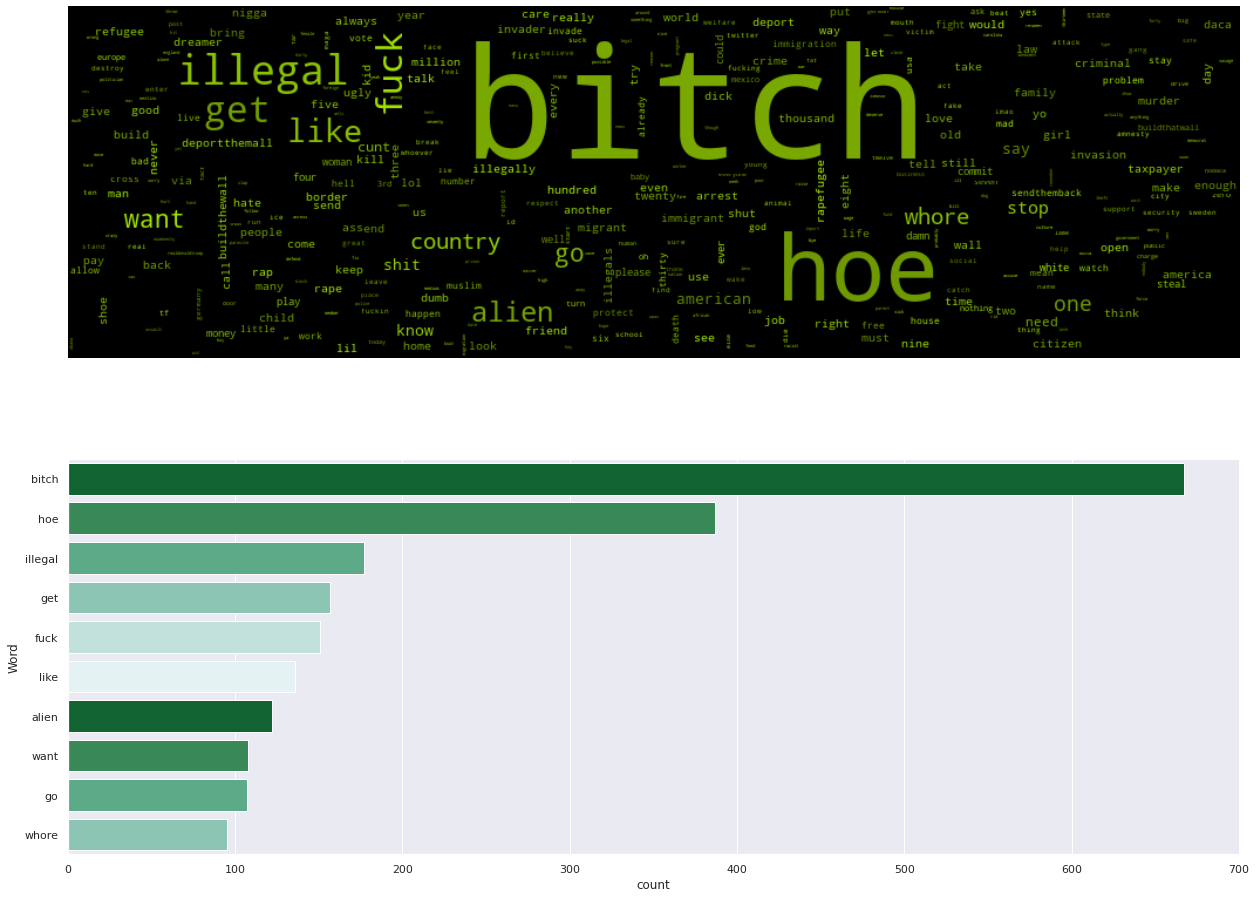

In [28]:
test_cloud=test_df[test_df['label']==1]
freq_words(test_cloud['text'], 10)

In [30]:
freq_words(val_df['text'], 30)

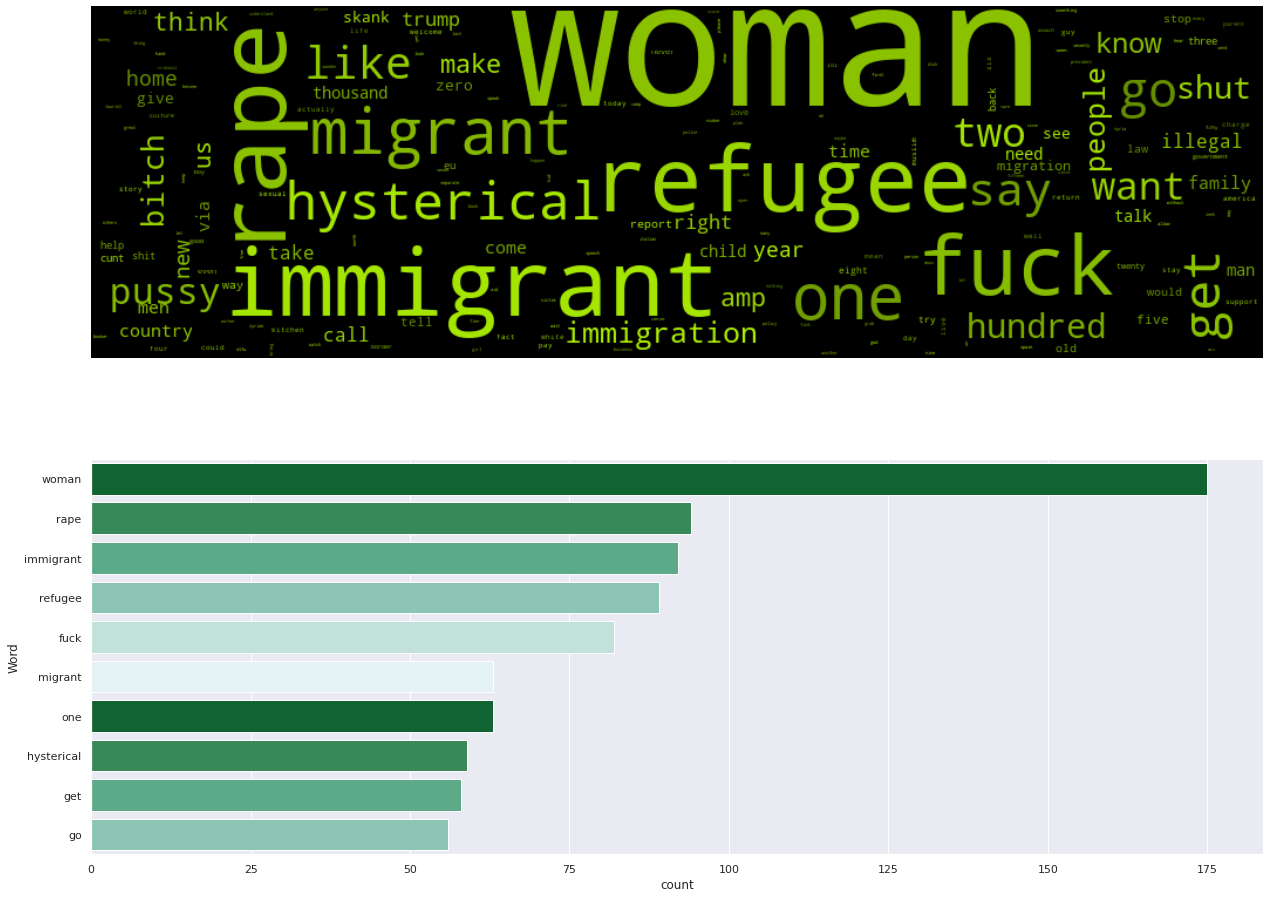

In [29]:
val_cloud=val_df[val_df['label']==0]
freq_words(val_cloud['text'], 10)

In [31]:
val_cloud=val_df[val_df['label']==1]
freq_words(val_cloud['text'], 10)